# Plant Disease Prediction

## Importing libraries

In [57]:
import tensorflow as tf
from tensorflow.keras import models, utils, optimizers
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import json
from zipfile import ZipFile
from PIL import Image
from IPython.display import HTML


## Data Preprocessing

### Training Image preprocessing

In [63]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.2, 0.2)
])

directory = 'data'
batch_size = 32
image_size = (128, 128)

training_set = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

# Apply augmentation to the dataset
training_set = training_set.map(lambda x, y: (data_augmentation(x), y))

# Optionally, you can shuffle and batch the dataset after augmentation
training_set = training_set.shuffle(1000).batch(batch_size)


Found 12 files belonging to 3 classes.


### Validation Image Preprocessing

In [64]:
validation_set = utils.image_dataset_from_directory(
    'data',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 12 files belonging to 3 classes.


In [66]:
class_names = validation_set.class_names
class_names


['Corn_(maize)___Common_rust_',
 'Potato___Early_blight',
 'Tomato___Bacterial_spot']

## Building Model

In [67]:
cnn = models.Sequential()

cnn.add(Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
cnn.add(MaxPool2D(pool_size=2,strides=2))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=2,strides=2))

cnn.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=2,strides=2))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=2,strides=2))

cnn.add(Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=2,strides=2))
cnn.add(Dropout(0.25))

cnn.add(Flatten())
cnn.add(Dense(units=1500,activation='relu'))
cnn.add(Dropout(0.4))

cnn.add(Dense(units=3,activation='softmax'))


c:\Users\harsh\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [68]:
cnn.compile(optimizer=optimizers.Adam(
    learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])


In [69]:
cnn.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1500)           │     1,537,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │         4,503 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,672,179 (6.38 MB)

 Trainable params: 1,672,179 (6.38 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
training_history = cnn.fit(x=training_set,validation_data=validation_set,epochs=10)


Epoch 1/10


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, None, 128, 128, 3), dtype=float32). Expected shape (None, 128, 128, 3), but input has incompatible shape (None, None, 128, 128, 3)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, None, 128, 128, 3), dtype=float32)
  • training=True
  • mask=None

## Evaluating Model

In [36]:
# Training Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3333 - loss: 1.6151
Training accuracy: 0.3333333432674408


In [37]:
# Validation Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3333 - loss: 1.6225


Validation accuracy: 0.3333333432674408


### Saving Model

In [38]:
cnn.save('trained_plant_disease_model.h5')


In [39]:
training_history.history


{'accuracy': [0.25,
  0.4166666567325592,
  0.25,
  0.25,
  0.3333333432674408,
  0.1666666716337204,
  0.25,
  0.5,
  0.4166666567325592,
  0.3333333432674408],
 'loss': [27.480186462402344,
  19.668516159057617,
  41.754337310791016,
  36.16636657714844,
  38.269554138183594,
  30.118688583374023,
  19.577238082885742,
  9.38807487487793,
  13.750533103942871,
  17.473623275756836],
 'val_accuracy': [0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408,
  0.25,
  0.3333333432674408,
  0.3333333432674408,
  0.3333333432674408],
 'val_loss': [4.455943584442139,
  6.369168758392334,
  6.668170928955078,
  8.384202003479004,
  5.7478861808776855,
  2.545842170715332,
  1.5849679708480835,
  1.604387640953064,
  1.5215635299682617,
  1.8189250230789185]}

In [40]:
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)


In [41]:
print(training_history.history.keys())


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


## Visualising results

In [42]:
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']


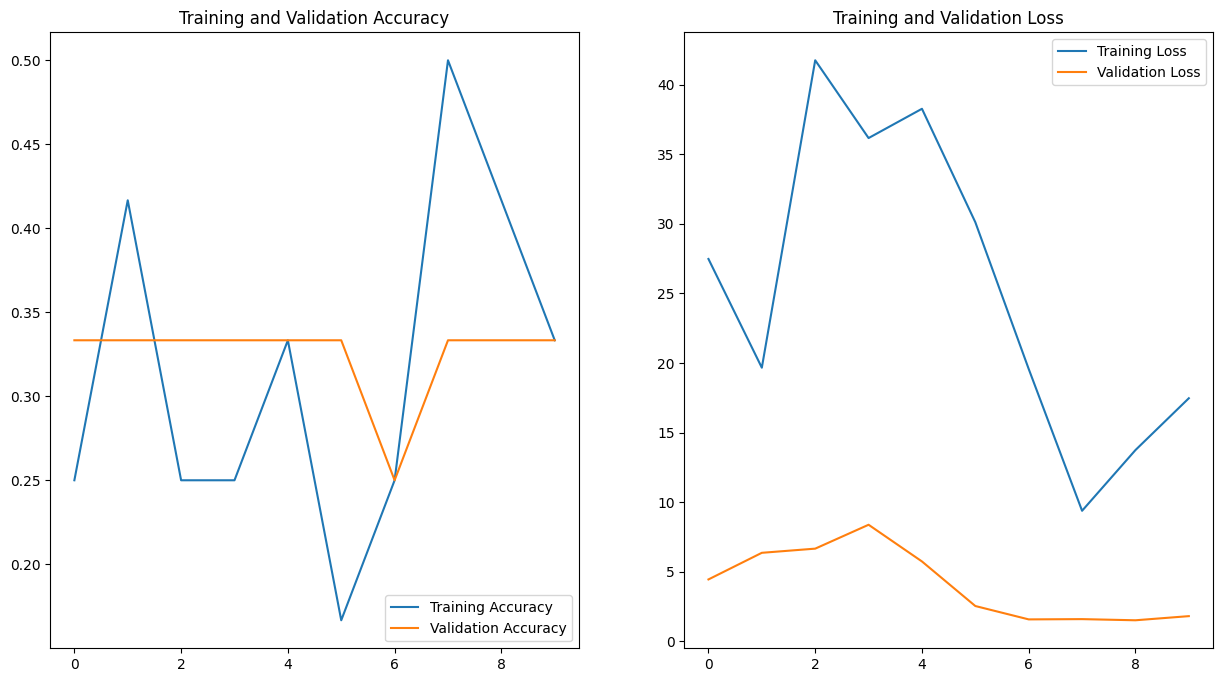

In [43]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


## Model evaluation

In [44]:
class_name = validation_set.class_names


In [45]:
len(class_name)


3

In [46]:
test_set = utils.image_dataset_from_directory(
    'data',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(128, 128),
    shuffle=False,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)


Found 12 files belonging to 3 classes.


In [47]:
# Predicted

y_pred = cnn.predict(test_set)
predicted_categories = tf.argmax(y_pred, axis=1)
predicted_categories


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


<tf.Tensor: shape=(12,), dtype=int64, numpy=array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)>

In [48]:
# Actual

true_categories = tf.concat([y for x, y in test_set], axis=0)
Y_true = tf.argmax(true_categories, axis=1)
Y_true


<tf.Tensor: shape=(12,), dtype=int64, numpy=array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2], dtype=int64)>

In [49]:
len(Y_true)


12

In [50]:
len(predicted_categories)


12

## Precision Recall Fscore

In [51]:
from sklearn.metrics import confusion_matrix,classification_report


In [52]:
# Precision Recall Fscore
print(classification_report(Y_true, predicted_categories, target_names=class_name))


                             precision    recall  f1-score   support

Corn_(maize)___Common_rust_       0.00      0.00      0.00         4
      Potato___Early_blight       0.33      1.00      0.50         4
    Tomato___Bacterial_spot       0.00      0.00      0.00         4

                   accuracy                           0.33        12
                  macro avg       0.11      0.33      0.17        12
               weighted avg       0.11      0.33      0.17        12



c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\harsh\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confusion Matrix Visualization

In [53]:
cm = confusion_matrix(Y_true, predicted_categories)


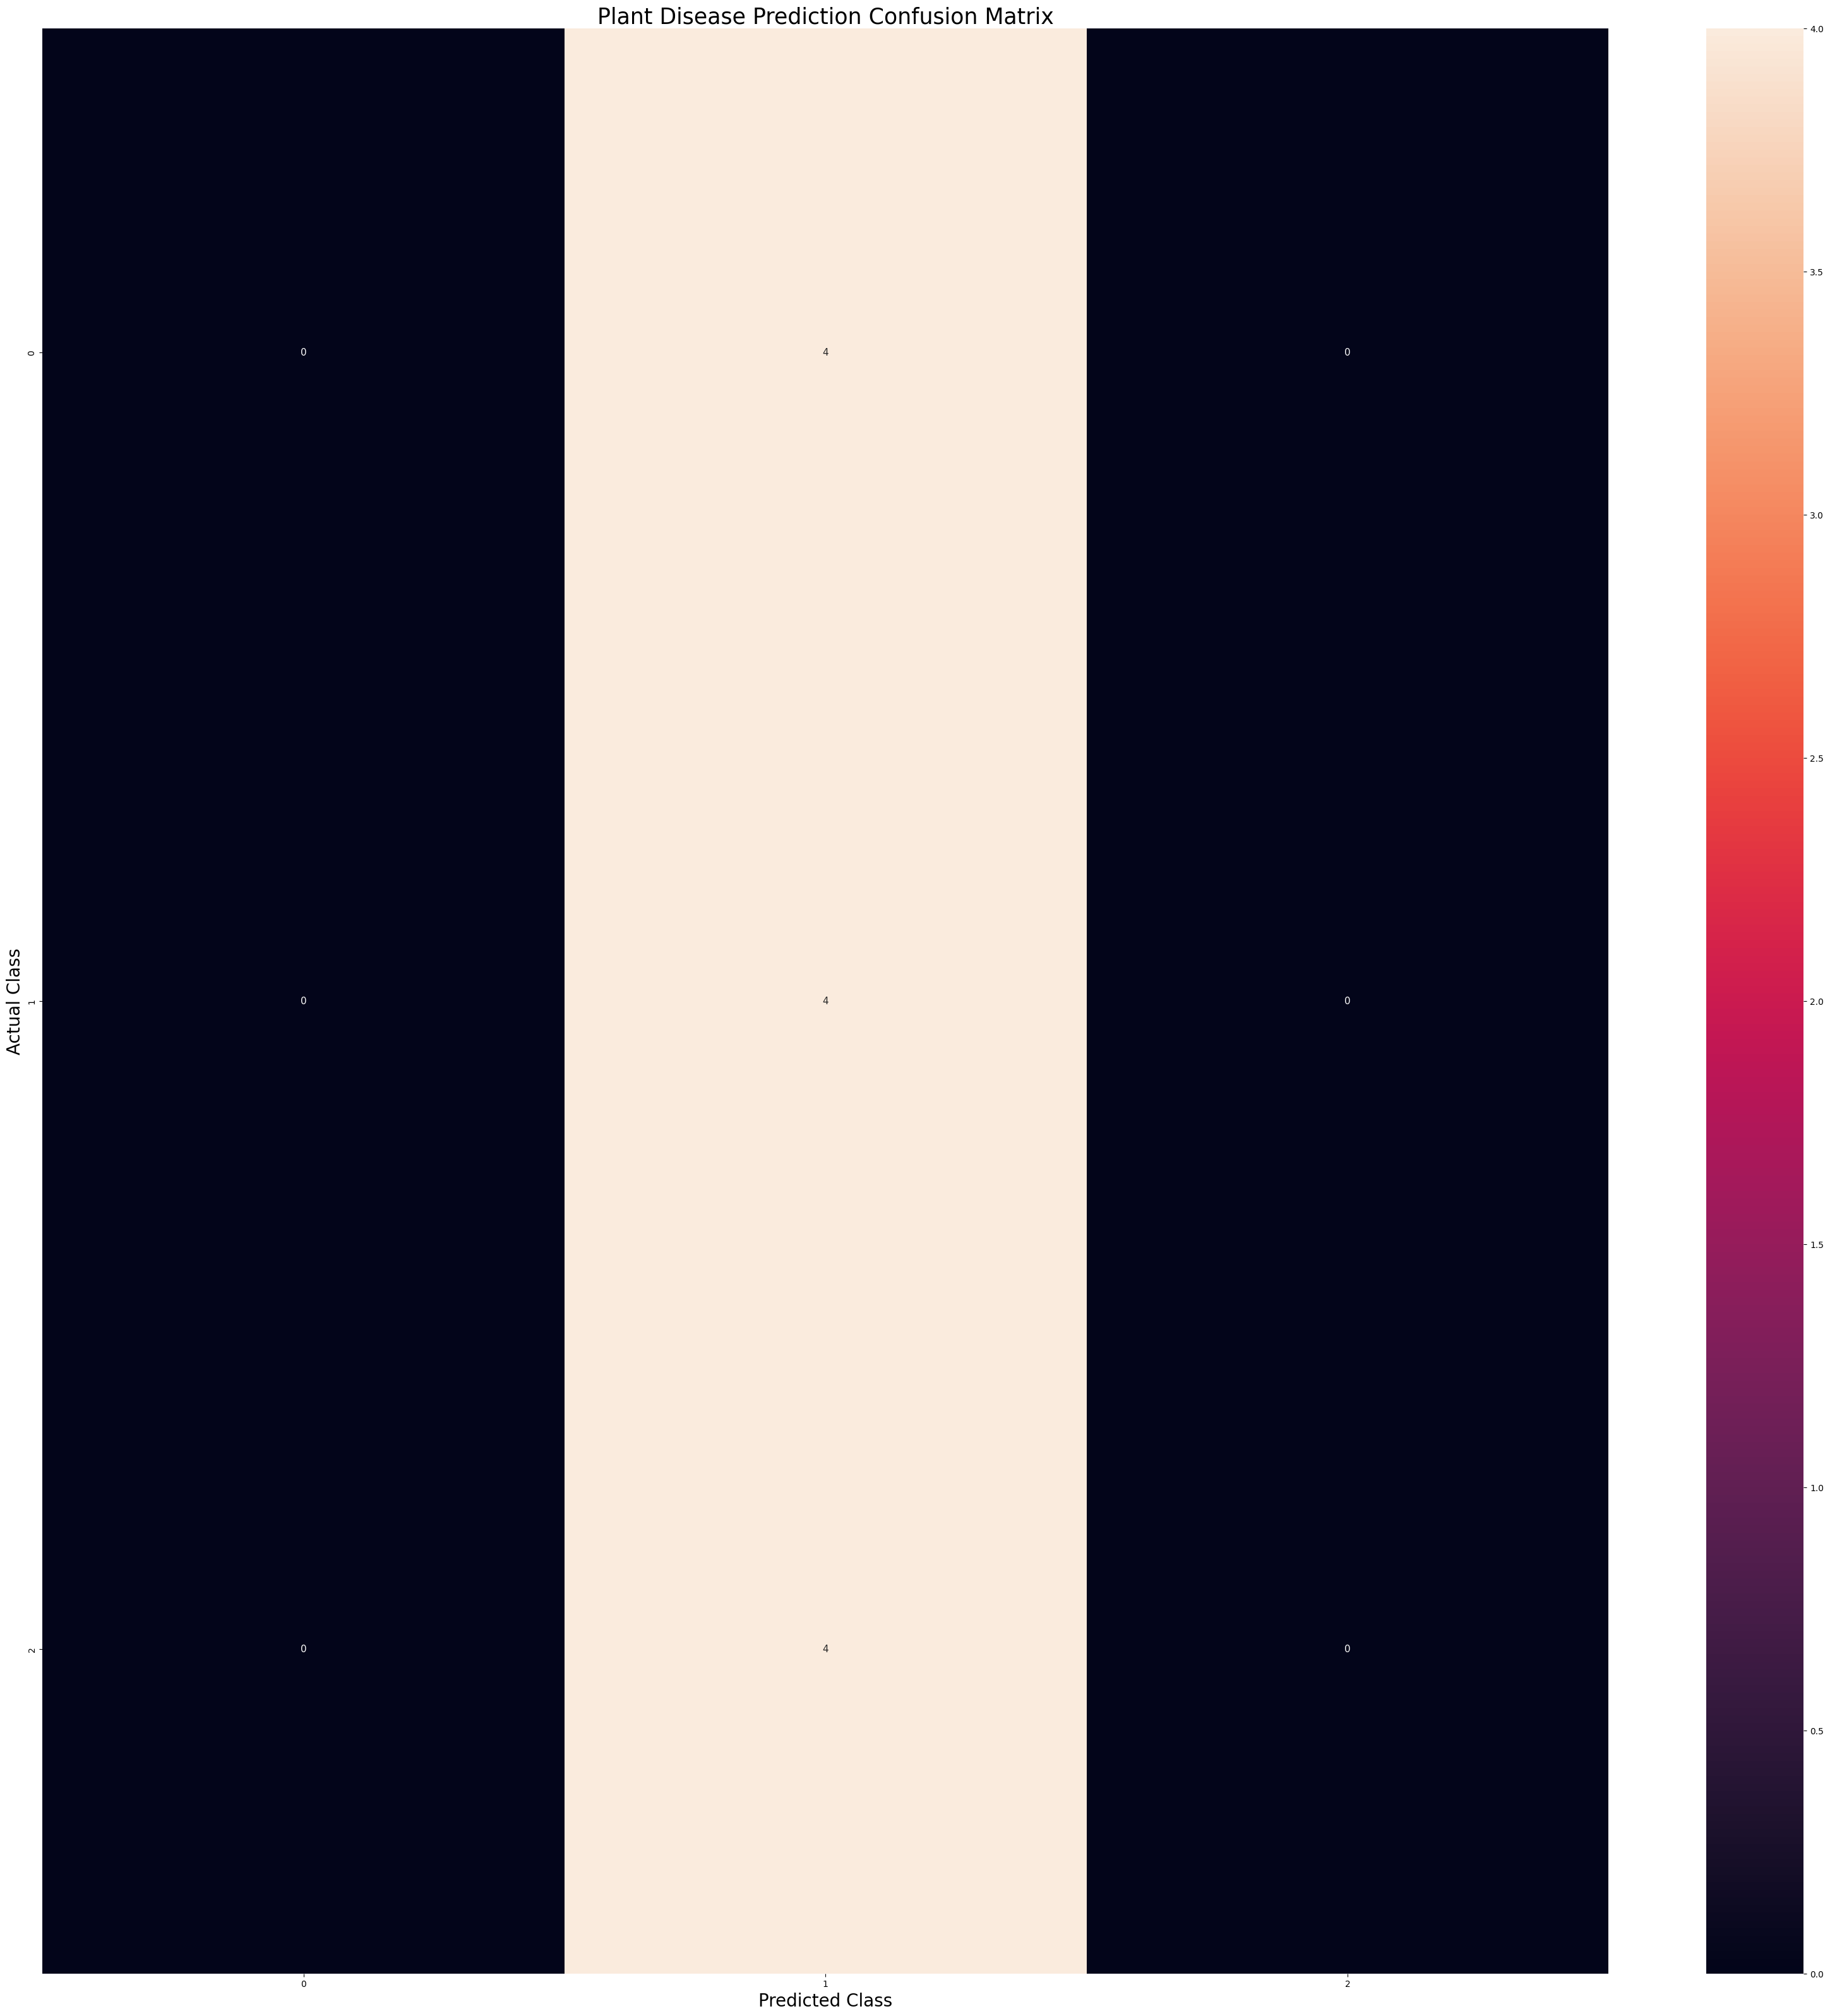

In [54]:
plt.figure(figsize=(40, 40))
sns.heatmap(cm,annot=True,annot_kws={"size": 11})

plt.xlabel('Predicted Class',fontsize = 20)
plt.ylabel('Actual Class',fontsize = 20)
plt.title('Plant Disease Prediction Confusion Matrix',fontsize = 25)
plt.show()
